# Import Libraries

Scrapping, Ultility and Helper functions

In [2]:
# Utility Libraries
import os
import time
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm, trange
from datetime import datetime, timedelta

# Logging for model training
import logging

# Custom helper functions
import sys
sys.path.append('.././script')

from dataprocessing import (display_topics, combine_pickle_files, 
                            expand_contractions, preprocessing_text)

from plotting import (graph_sentiment_profit, best_threshold, 
                      best_threshold2, threshold_vs_profit, model_profit_graph)

from modelling import (custom_train_test_split, build_timeseries, 
                       trim_dataset, create_model)

from scrapes import (load_soup, scrape_bitcoin_news_google, scrape_bitcoin_price)

# Web Scraping Libraries
from bs4 import BeautifulSoup
from lxml import html
import requests


Visualisation

In [ ]:
# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

NLP Library

In [ ]:

# Natural Language Processing (NLP) Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from contractions import CONTRACTION_MAP
import nltk
from nltk.tokenize import MWETokenizer, word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
import en_core_web_md

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Preprocessing Libraries
from gensim import corpora, models
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Text processing utilities
from sklearn.decomposition import NMF
from spacy import displacy
from sklearn import preprocessing
from nltk.tokenize.toktok import ToktokTokenizer

# Initialize Spacy and Stopwords
nlp_model = en_core_web_md.load()
tokenizer = ToktokTokenizer()
stop_words = stopwords.words('english')
custom_stopwords = ['crypto', 'cryptocurrencies', 'Cryptocurrency', 'btc', 'bitcoin', 'Bitcoin']
stop_words += custom_stopwords

LSTM Modelling

In [ ]:
# Modeling Libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import tensorflow as tf
from sklearn.metrics import mean_squared_error

# Scraping for news dataset

Scraping data from Google News

In [4]:
# Create "news_data" folder if it's not there
git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
if 'news_data' not in os.listdir(git_folder_location):
    !mkdir 'news_data'

# Create "price_data" folder if it's not there
git_folder_location = os.path.abspath(os.path.dirname('bitcoin_trader'))
if 'price_data' not in os.listdir(git_folder_location):
    !mkdir price_data

# Scrape Data by passing in start_date, end_date, num_articles_per_day
scrape_bitcoin_news_google(date(2019, 6, 8),date(2019, 8, 13),40) #date.today()

# Combine individual day pickle files & pickle it
df_news_raw = combine_pickle_files('news_data')
df_news_raw.sort_values(by=['date'],inplace=True)
df_news_raw.reset_index(drop=True,inplace=True)
with open('df_news_raw.pkl','wb') as picklefile:
    pickle.dump(df_news_raw,picklefile)

Clean and Save DataFrame

In [17]:
# Load df_news_raw
with open('df_news_raw.pkl', 'rb') as picklefile: 
    df_news_raw = pickle.load(picklefile) 
    
# Combine title & intro
df_news_raw['text'] = df_news_raw['title']+'. '+df_news_raw['intro']

df_news_clean = []

# Apply preprocessing function to the 'text' column of the DataFrame
df_news_clean['preprocessed_text'] = df_news_raw['text'].apply(preprocess_text)
df_news_clean['preprocessed_text'] = df_news_clean['preprocessed_text'].apply(lambda text: text.split())

with open('df_news_clean.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

# Topic Modeling

## Tf-idf & LDA

(24391, 799)


[(0,
  '0.057*"mining" + 0.036*"eth" + 0.031*"miner" + 0.030*"ltc" + 0.021*"mine" + 0.017*"tweet" + 0.015*"electricity" + 0.015*"wall" + 0.014*"energy" + 0.014*"street"'),
 (1,
  '0.055*"libra" + 0.036*"tax" + 0.020*"tether" + 0.019*"irs" + 0.016*"court" + 0.015*"authority" + 0.011*"rule" + 0.011*"regulatory" + 0.011*"russia" + 0.011*"study"'),
 (2,
  '0.020*"launch" + 0.018*"platform" + 0.018*"payment" + 0.017*"wallet" + 0.016*"coinbase" + 0.016*"accept" + 0.014*"service" + 0.014*"announce" + 0.013*"user" + 0.012*"base"'),
 (3,
  '0.032*"binance" + 0.028*"usd" + 0.025*"altcoin" + 0.023*"break" + 0.017*"trading" + 0.015*"analysis" + 0.015*"volume" + 0.014*"june" + 0.012*"range" + 0.012*"ethereum"'),
 (4,
  '0.013*"prediction" + 0.012*"attack" + 0.011*"analyst" + 0.010*"towards" + 0.010*"predict" + 0.009*"go" + 0.009*"many" + 0.009*"cryptos" + 0.009*"point" + 0.009*"popular"'),
 (5,
  '0.041*"ban" + 0.021*"china" + 0.018*"scam" + 0.015*"india" + 0.014*"wild" + 0.013*"chinas" + 0.013*"po

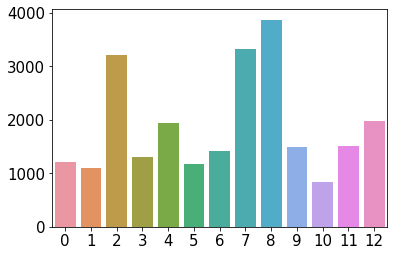

In [442]:
# Set up TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stopword_list, max_df=0.08, min_df=0.004)
doc_word = tfidf_vectorizer.fit_transform(df_news_clean['title_intro_clean'])

# Convert sparse matrix to gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.T)  # Transpose directly here
id2word = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}  # Dictionary comprehension

# LDA model
lda_model = models.LdaMulticore(corpus=corpus, num_topics=13, id2word=id2word, passes=5, workers=1)

# Get LDA topic vectors for documents
lda_docs = [doc for doc in lda_model[corpus]]

# Extract dominant topic for each document
doc_cluster = [max(doc, key=lambda x: x[1])[0] for doc in lda_docs]

# Plot topic distribution
sns.barplot(x=pd.Series(doc_cluster).value_counts().index, y=pd.Series(doc_cluster).value_counts().values)

# View topics
lda_model.print_topics()

Topic selection based on the LDA topic modelling result

In [673]:
topic_mapping={
                0:'Cryptocurrency Mining',
                1:'Tax Related',
                2:'Technology',
                3:'Binance - Biggest Crypto Trading Platform',
                4:'Market Analysis',
                5:'International - China and India',
                6:'Hackers/Stealing'  ,
                7:'Venezuela and Cryptocurrency', #Venezuela has hyperinflation with national currency resulting to people trusting cryptos
                8:'Market',
                9:'Different Cryptocurrencies',
                10:'Satoshi Nakamoto',
                11:'Facebook',
                12:'Regulations'}

Update Dataframe with our chosen Topics

In [667]:
df_topics = []
for vec in vec_topics:
    sorted_x = sorted(vec, key=operator.itemgetter(1))
    sorted_x.reverse()
    df_topics.append(topic_mapping[sorted_x[0][0]])
with open('df_news_clean_topic.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

Plot Topic Trends Over Time

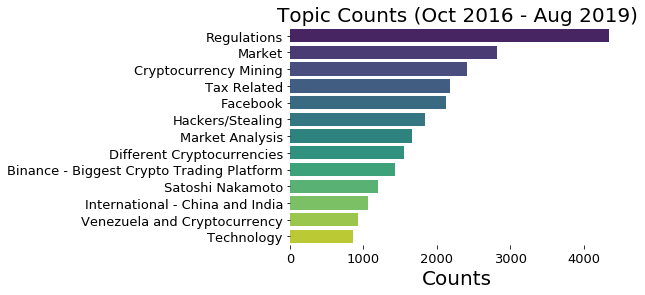

In [793]:
sns.barplot(y=df_news_clean_topic['topic'].value_counts().keys(),
            x=df_news_clean_topic['topic'].value_counts().values,
            palette="viridis")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels


plt.xlabel('Counts')
plt.title('Topic Counts (Oct 2016 - Aug 2019)');

Ploting topic count for each topic in time-series

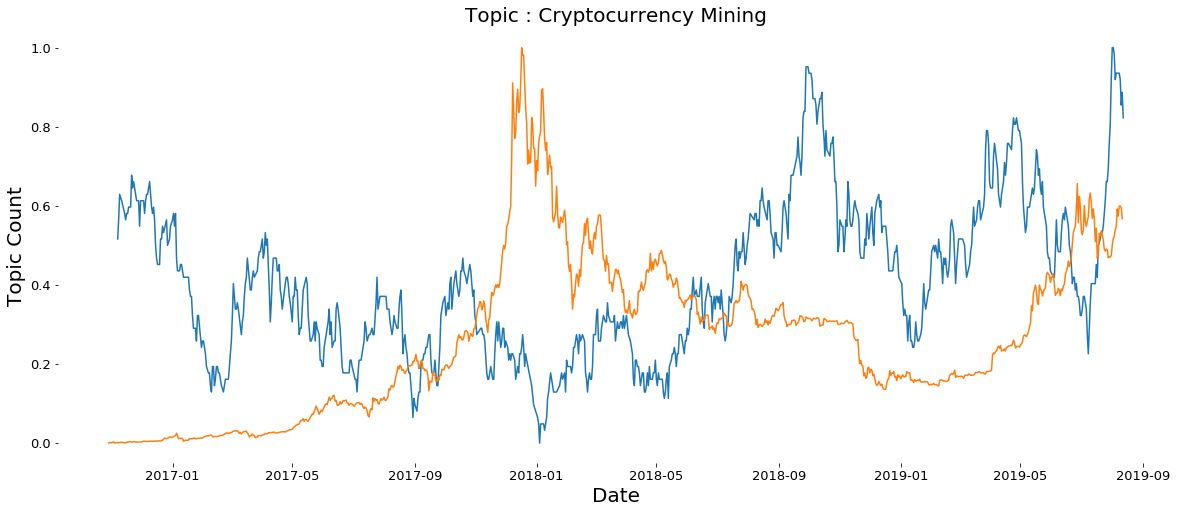

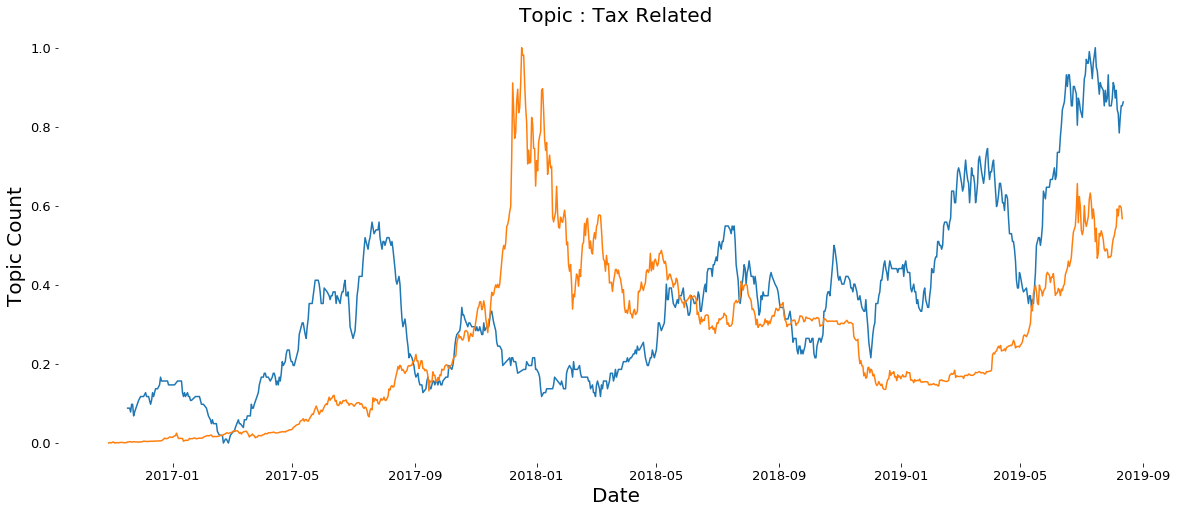

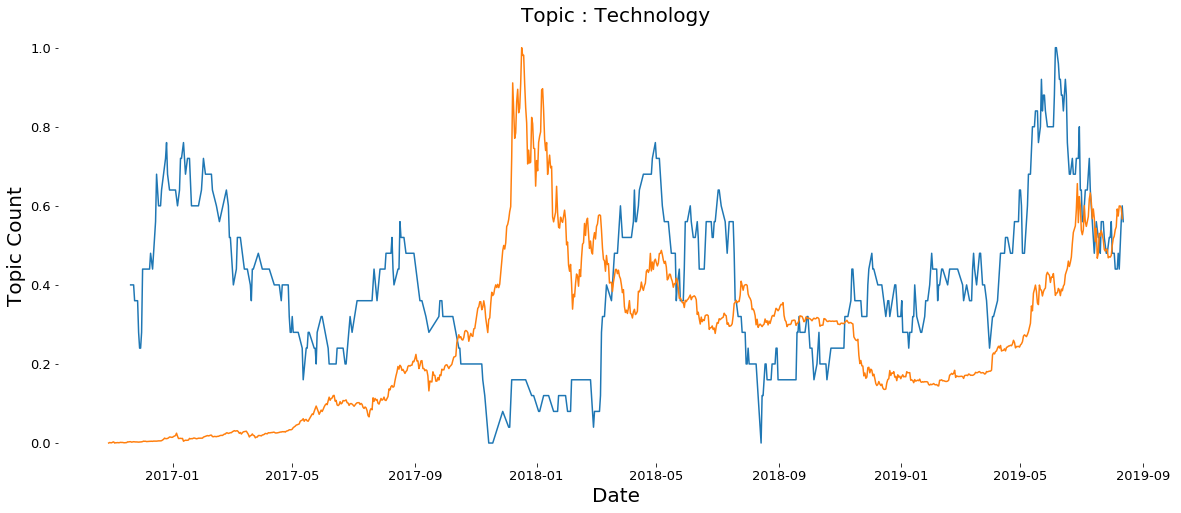

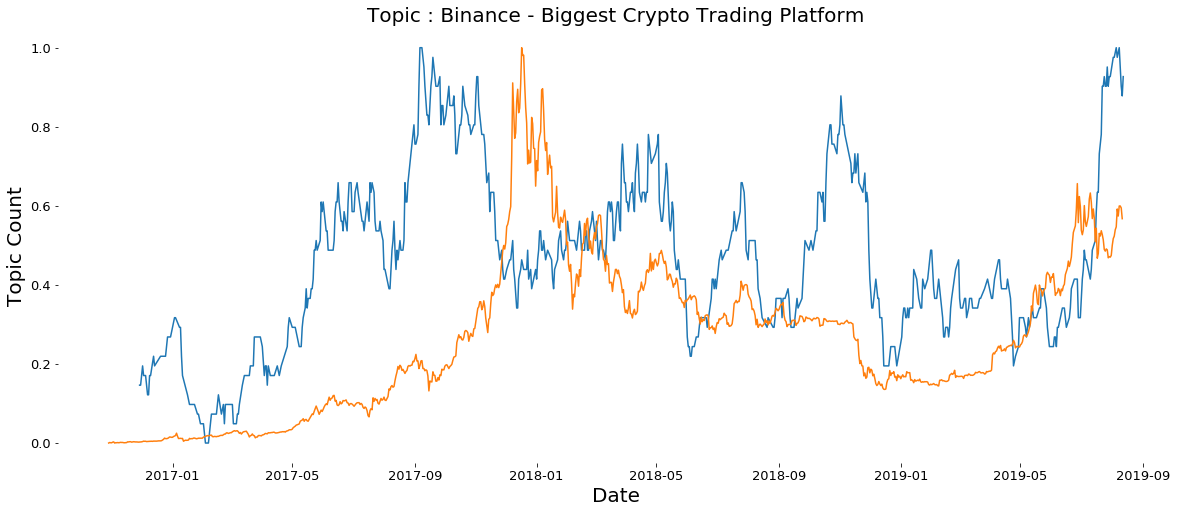

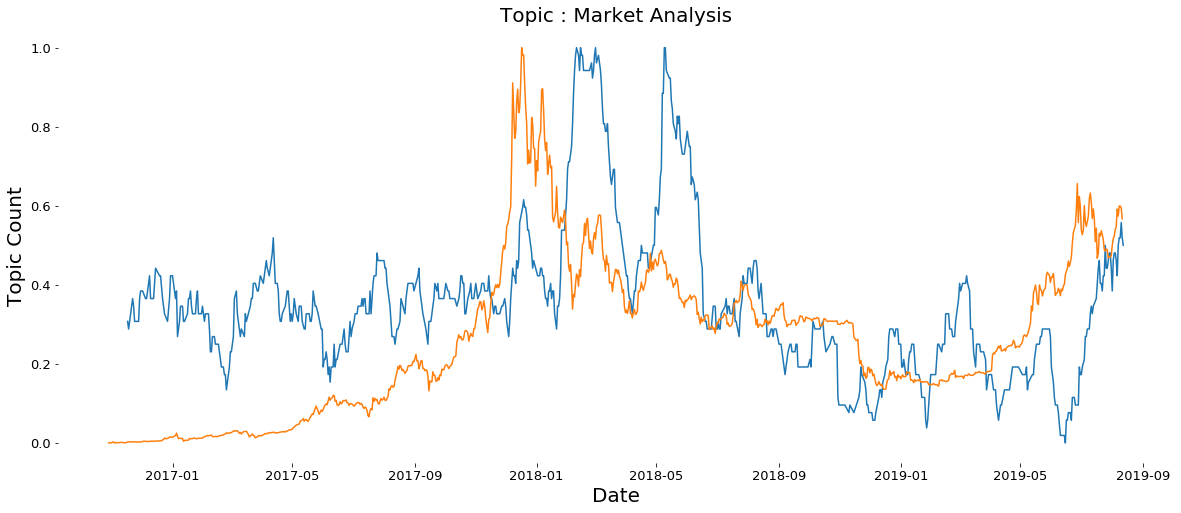

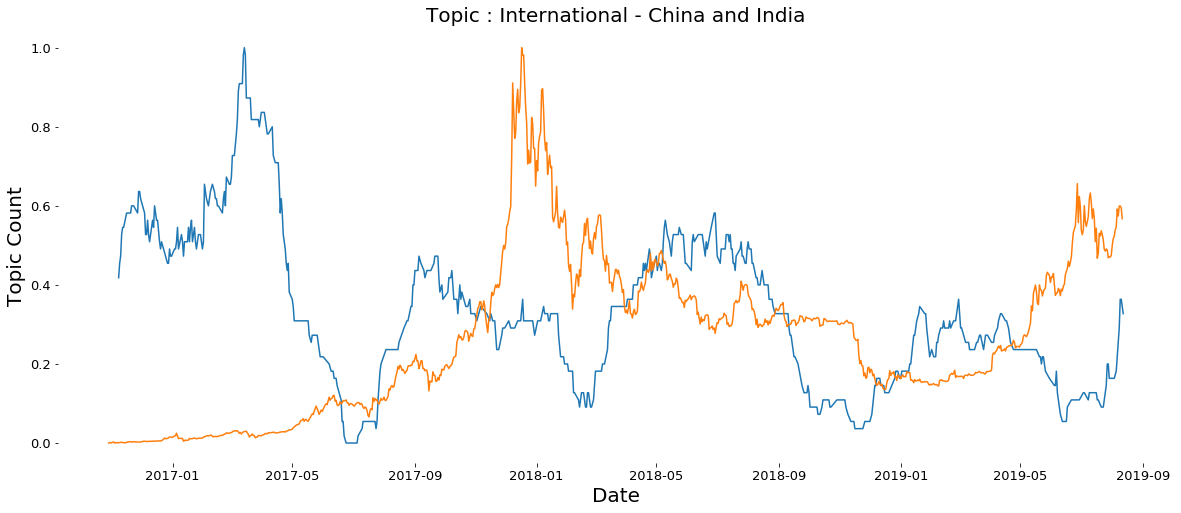

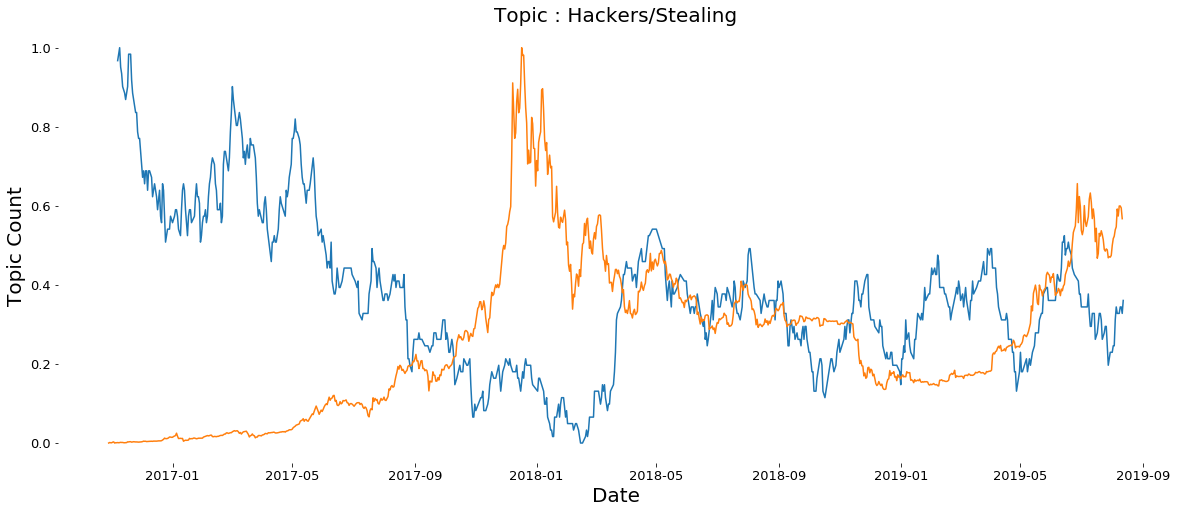

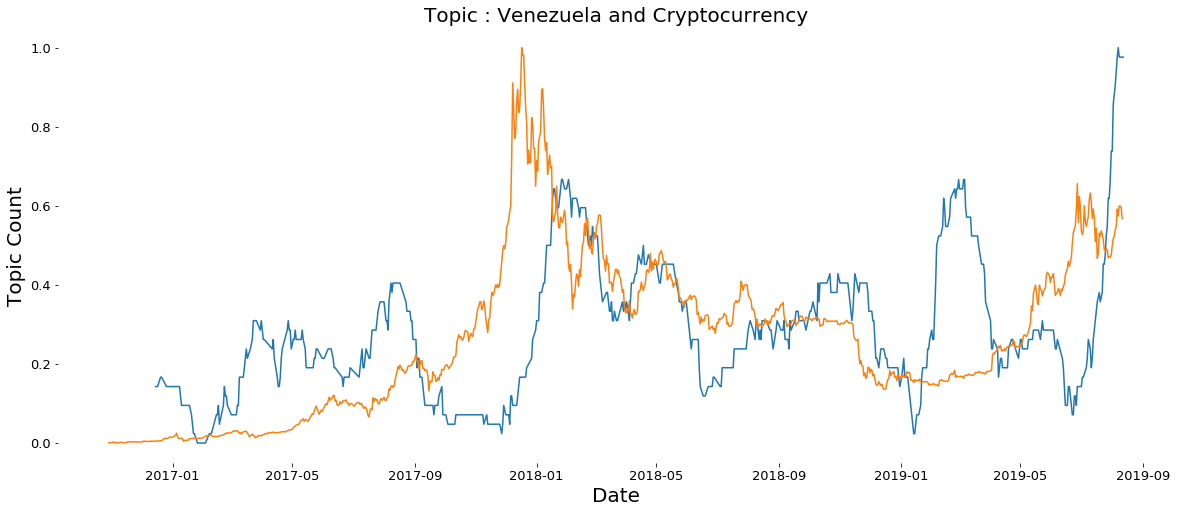

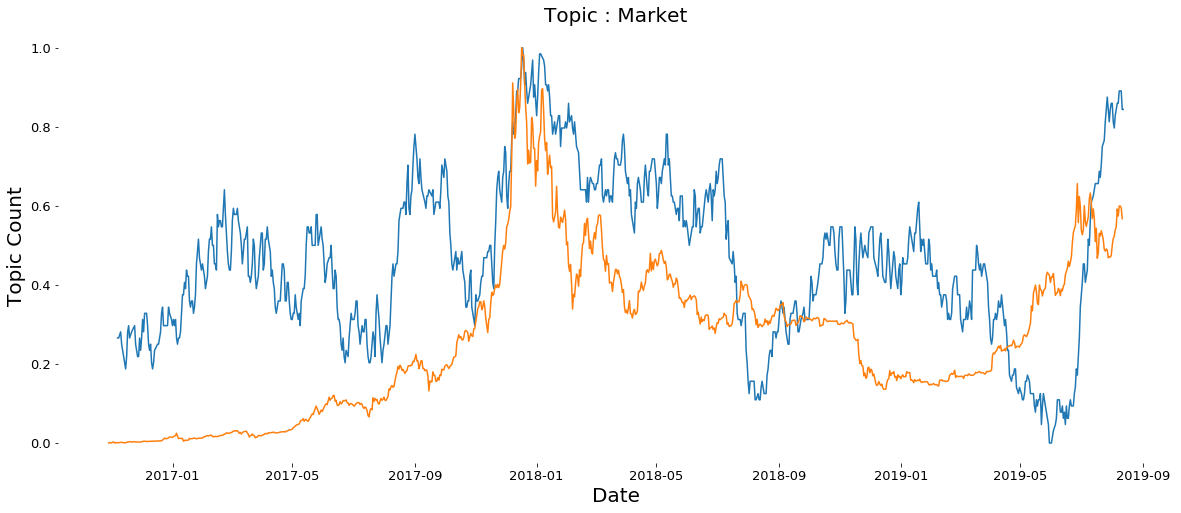

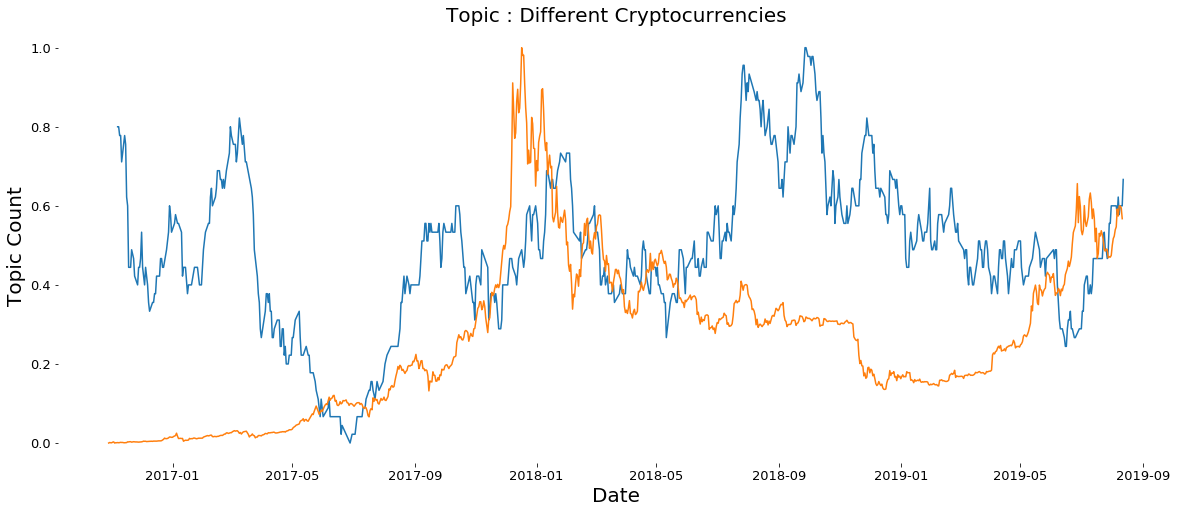

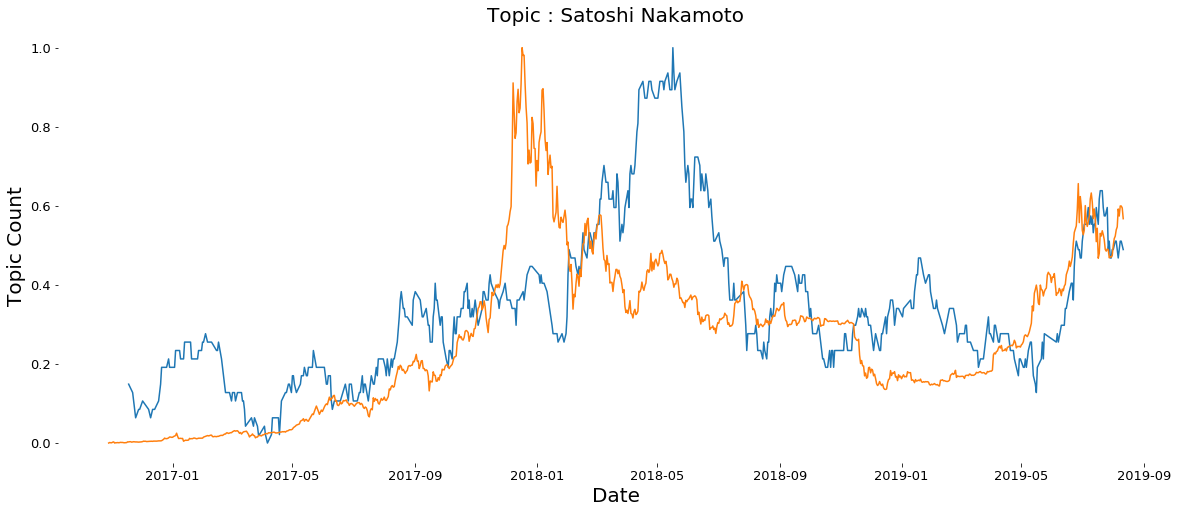

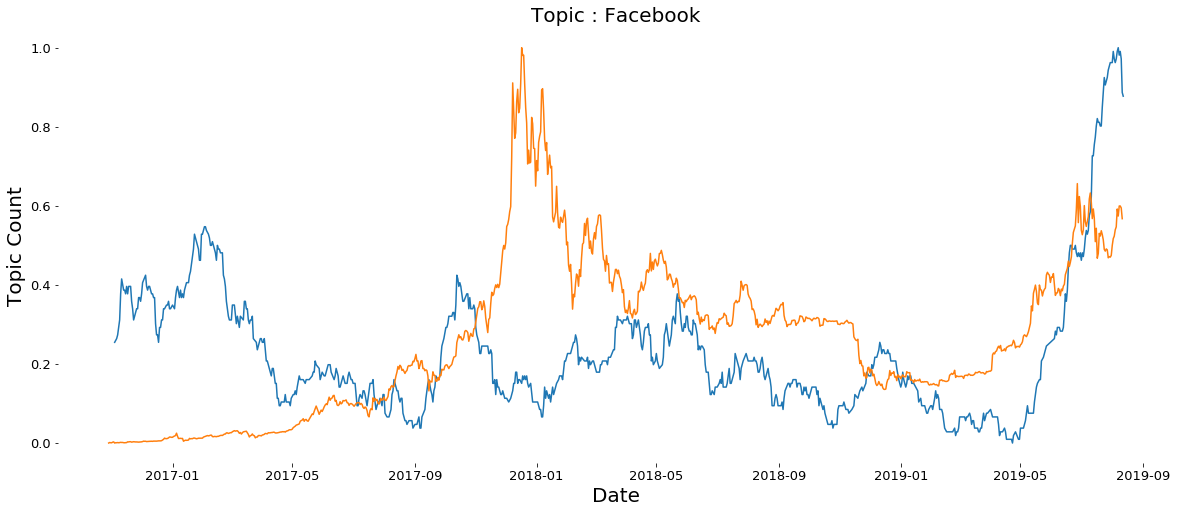

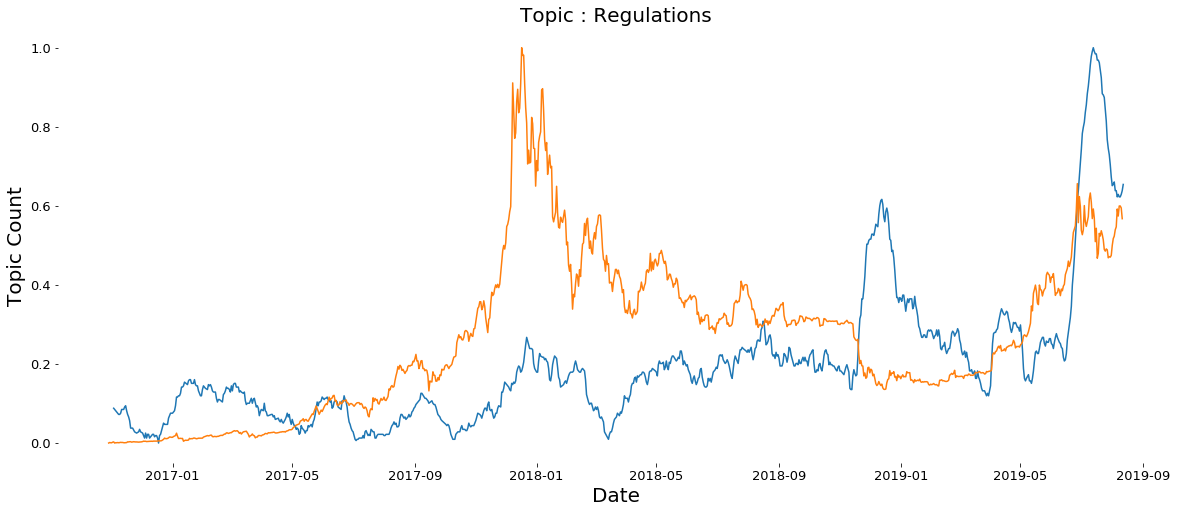

In [778]:
with open('df_news_clean_topic.pkl', 'rb') as picklefile: 
    df_news_clean_topic = pickle.load(picklefile)
    min_max_scaler = preprocessing.MinMaxScaler()
for topic in list(topic_mapping.values()):
    topic_df = df_news_clean_topic[df_news_clean_topic['topic']==topic].groupby(by=['date'],as_index=False).count()
    plt.figure(figsize=(20,8))
    sns.lineplot(x=topic_df['date'],y=min_max_scaler.fit_transform(np.array(topic_df['topic'].rolling(30).mean()).reshape(-1,1)).reshape(-1))
    sns.lineplot(x=df_daily['date'],y=min_max_scaler.fit_transform(df_daily['open'].values.reshape(-1,1)).reshape(-1))


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    #plt.axvline(x=date(2018, 9, 1),color='r',linestyle ='-.' )  #vertical line. Linestype : ['-', '--', '-.', ':', '',]

    plt.xlabel('Date')
    plt.ylabel('Topic Count')
    plt.title('Topic : {}'.format(topic))
    plt.show() 
    

# Sentiment Analysis

Get Vader and Textblob sentiment analysis and add the score to the dataframe

In [ ]:
# Load df_news_clean
with open('df_news_clean.pkl', 'rb') as picklefile: 
    df_news_clean = pickle.load(picklefile)

pos_list = ['rally', 'bounce', 'bullish', 'bull']
neg_list = ['bearish','bear','dip']


analyser = SentimentIntensityAnalyzer()

    
def replace_terms(text, pos_list, neg_list):
    if text is None:
        return ''
    for word in pos_list:
        text = text.replace(word, 'good')
    for word in neg_list:
        text = text.replace(word, 'bad')
    return text

def get_vader_sentiment(text):
    return analyser.polarity_scores(text)

def get_textblob_sentiment(text):
    return np.round(TextBlob(text).sentiment.polarity, 4)
     

df_news_clean['text'] = df_news_clean['text'].apply(replace_terms, args=(pos_list, neg_list))

df_news_clean['vader_sentiment'] = df_news_clean['text'].apply(get_vader_sentiment)
df_news_clean['vader_compound'] = df_news_clean['vader_sentiment'].apply(lambda x: x['compound'])

df_news_clean['textblob_sentiment'] = df_news_clean['text'].apply(get_textblob_sentiment)

df_news_clean['vader+textblob_sentiment'] = (df_news_clean['vader_compound'] + df_news_clean['textblob_sentiment'])/2

with open('df_news_sentiment.pkl','wb') as picklefile:
    pickle.dump(df_news_clean,picklefile)

Scraping Bitcoin Price and add to the dataframe

In [88]:
# Load df_news_clean
with open('df_news_sentiment.pkl', 'rb') as picklefile: 
    df_news_sentiment = pickle.load(picklefile)
    
# Scrape Bitcoin Price Table
start_date = min(df_news_sentiment['date']).strftime("%Y%m%d")
end_date = max(df_news_sentiment['date']).strftime("%Y%m%d")
df_price = scrape_bitcoin_price(start_date,end_date)

# get daily sentiment score by getting mean of sentiments & concat it with bitcoin price data
df_daily = df_news_sentiment.groupby(['date'], as_index=False).mean().copy()
df_daily = pd.concat([df_daily,df_price[['open', 'high', 'low', 'close', 'volume', 'market_cap']]],axis=1)

Generate additional long term and short term features and add to the dataframe

In [ ]:
# Generate More Features
df_daily['percent_change_volume'] = (df_daily['volume'].shift(1)-df_daily['volume'])/df_daily['volume'].shift(1)
df_daily['percent_change_daily_open'] = (df_daily['open'].shift(1)-df_daily['open'])/df_daily['open'].shift(1)
df_daily['percent_change_wkly_open'] = (df_price['open'].rolling(7).mean().shift(1)-df_price['open'].rolling(7).mean())/df_price['open'].rolling(7).mean().shift(1)
df_daily['percent_change_monthly_open'] = (df_price['open'].rolling(28).mean().shift(1)-df_price['open'].rolling(28).mean())/df_price['open'].rolling(28).mean().shift(1)
df_daily['percent_change_daily_close'] = (df_daily['close'].shift(1)-df_daily['close'])/df_daily['close'].shift(1)
df_daily['percent_change_wkly_close'] = (df_price['close'].rolling(7).mean().shift(1)-df_price['close'].rolling(7).mean())/df_price['close'].rolling(7).mean().shift(1)
df_daily['daily_sentiment_change'] = (df_daily['vader+textblob_sentiment'].shift(1)-df_daily['vader+textblob_sentiment'])/df_daily['vader+textblob_sentiment'].shift(1)
df_daily['wkly_sentiment_change'] = (df_daily['vader+textblob_sentiment'].rolling(7).mean().shift(1)-df_daily['vader+textblob_sentiment'].rolling(7).mean())/df_daily['vader+textblob_sentiment'].rolling(7).mean().shift(1)
df_daily['2wk_sentiment_change'] = (df_daily['vader+textblob_sentiment'].rolling(14).mean().shift(1)-df_daily['vader+textblob_sentiment'].rolling(14).mean())/df_daily['vader+textblob_sentiment'].rolling(14).mean().shift(1)
df_daily['3wk_sentiment_change'] = (df_daily['vader+textblob_sentiment'].rolling(21).mean().shift(1)-df_daily['vader+textblob_sentiment'].rolling(21).mean())/df_daily['vader+textblob_sentiment'].rolling(21).mean().shift(1)
df_daily['4wk_sentiment_change'] = (df_daily['vader+textblob_sentiment'].rolling(28).mean().shift(1)-df_daily['vader+textblob_sentiment'].rolling(28).mean())/df_daily['vader+textblob_sentiment'].rolling(28).mean().shift(1)
df_daily['target_daily'] = df_daily['percent_change_daily_open'].shift(-1)
df_daily.dropna(inplace=True)
df_daily.reset_index(drop=True,inplace=True)

# Pickle df_daily
with open('df_daily.pkl','wb') as picklefile:
    pickle.dump(df_daily,picklefile)

# Load df_news_clean
with open('df_daily.pkl', 'rb') as picklefile: 
    df_daily = pickle.load(picklefile)

## Sentiment EDA

### Sentiment vs Bitcoin Price 

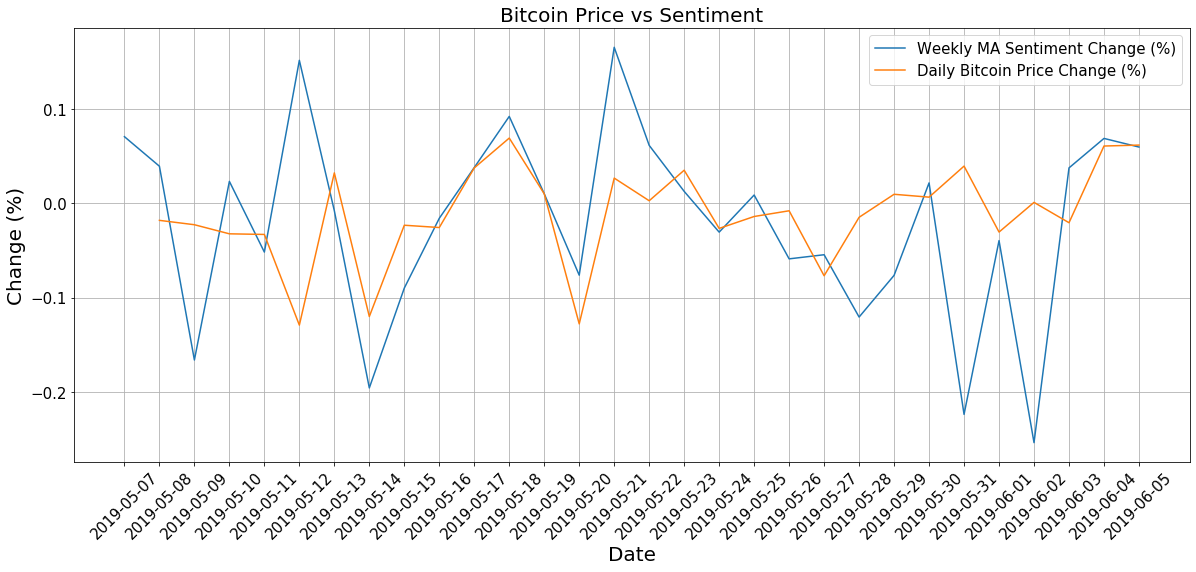

In [90]:
#date range for x axis
start_index = 420
end_index = 500

fig, ax1 = plt.subplots(figsize=(20, 8))

sns.lineplot(x=df_daily['date'][start_index:end_index], y=df_daily['2min_sentiment_change_percentage'][start_index:end_index], ax=ax1, color='blue', label='Sentiment Change (%)')
ax1.set_ylabel('Sentiment Change (%)', color='blue')


ax2 = ax1.twinx()
sns.lineplot(x=df_daily['date'][start_index+1:end_index+1], y=df_daily['2min_price_change_percentage'][start_index:end_index], ax=ax2, color='red', label='Price Change (%)')
ax2.set_ylabel('Price Change (%)', color='red')

plt.title('Bitcoin Price vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(df_daily['date'][start_index:end_index], rotation=45)


plt.grid()
plt.show()

### Sentiment Differences

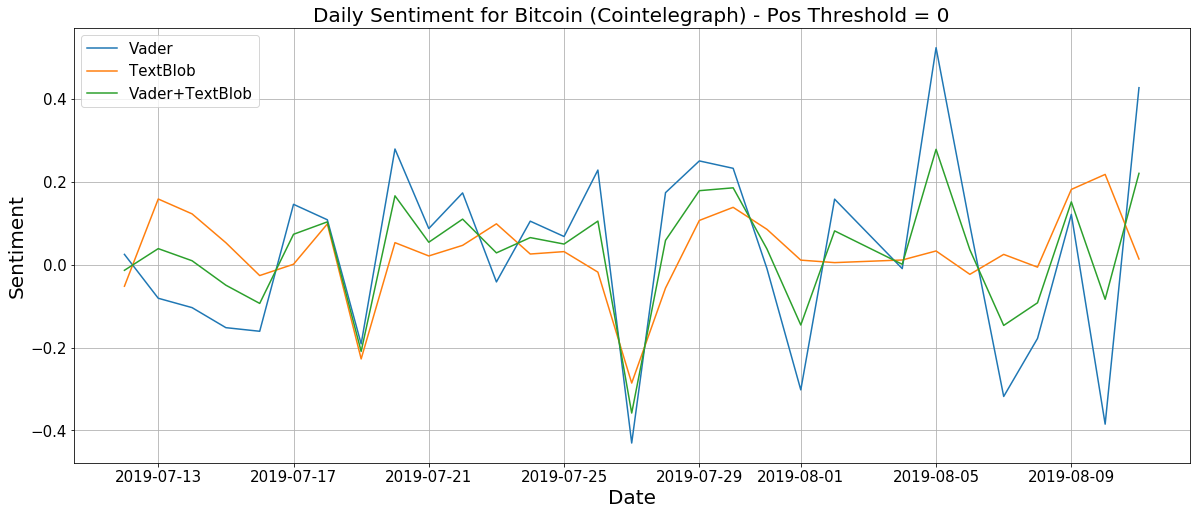

In [91]:
# Define font sizes for plot
TICK_LABEL_SIZE = 15
AXIS_LABEL_SIZE = 20
FIGURE_TITLE_SIZE = 40
sentiment_threshold = 0

# Set default plot parameters for font sizes
plt.rc('font', size=AXIS_LABEL_SIZE)          # Default text size
plt.rc('axes', titlesize=AXIS_LABEL_SIZE)     # Axes title size
plt.rc('axes', labelsize=AXIS_LABEL_SIZE)     # Axes label size
plt.rc('xtick', labelsize=TICK_LABEL_SIZE)    # X-axis tick label size
plt.rc('ytick', labelsize=TICK_LABEL_SIZE)    # Y-axis tick label size
plt.rc('legend', fontsize=TICK_LABEL_SIZE)    # Legend text size
plt.rc('figure', titlesize=FIGURE_TITLE_SIZE) # Figure title size

# Assign the first publisher from the top 5 publishers list
selected_publisher = top_5_publishers[0]

# Create a DataFrame of daily sentiment by publisher
publisher_sentiment_df = df_news_sentiment.groupby(by=['date', 'publisher'], as_index=False).mean()

# Filter the data for the selected publisher
selected_publisher_sentiment = publisher_sentiment_df[publisher_sentiment_df['publisher'] == selected_publisher]

# Merge the sentiment data with daily sentiment changes
selected_publisher_sentiment = selected_publisher_sentiment.merge(
    df_daily[['date', 'daily_sentiment_change', 'target_daily']],
    on='date'
)

# Apply buy/sell logic using Vader sentiment
selected_publisher_sentiment['vader_buy_sell'] = selected_publisher_sentiment['compound'].apply(
    lambda x: 1 if x > sentiment_threshold else 0
)
selected_publisher_sentiment['vader_profit'] = (
    selected_publisher_sentiment['vader_buy_sell'] * 100 * selected_publisher_sentiment['target_daily']
)

# Apply buy/sell logic using TextBlob sentiment
selected_publisher_sentiment['textblob_buy_sell'] = selected_publisher_sentiment['txtblob'].apply(
    lambda x: 1 if x > sentiment_threshold else 0
)
selected_publisher_sentiment['textblob_profit'] = (
    selected_publisher_sentiment['textblob_buy_sell'] * 100 * selected_publisher_sentiment['target_daily']
)

# Apply buy/sell logic using combined Vader + TextBlob sentiment
selected_publisher_sentiment['combined_buy_sell'] = selected_publisher_sentiment['final_sentiment'].apply(
    lambda x: 1 if x > sentiment_threshold else 0
)
selected_publisher_sentiment['combined_profit'] = (
    selected_publisher_sentiment['combined_buy_sell'] * 100 * selected_publisher_sentiment['target_daily']
)

# Apply buy/sell logic using daily sentiment change
selected_publisher_sentiment['daily_change_buy_sell'] = selected_publisher_sentiment['daily_sentiment_change'].apply(
    lambda x: 1 if x > sentiment_threshold else 0
)
selected_publisher_sentiment['daily_change_profit'] = (
    selected_publisher_sentiment['daily_change_buy_sell'] * 100 * selected_publisher_sentiment['target_daily']
)

# Drop any rows with missing values
selected_publisher_sentiment.dropna(inplace=True)

# Define the range for plotting (last 30 days)
start_index = len(selected_publisher_sentiment) - 30
end_index = len(selected_publisher_sentiment)

# Plot the sentiment data
plt.figure(figsize=(20, 8))
sns.lineplot(x=selected_publisher_sentiment['date'][start_index:end_index],
             y=selected_publisher_sentiment['compound'][start_index:end_index], label='Vader')
sns.lineplot(x=selected_publisher_sentiment['date'][start_index:end_index],
             y=selected_publisher_sentiment['txtblob'][start_index:end_index], label='TextBlob')
sns.lineplot(x=selected_publisher_sentiment['date'][start_index:end_index],
             y=selected_publisher_sentiment['vader+textblob_sentiment'][start_index:end_index], label='Vader+TextBlob')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title(f'Daily Sentiment for Bitcoin ({selected_publisher}) - Pos Threshold = {sentiment_threshold}')
plt.legend()
plt.grid(True)
plt.show()

### Choosing Article from Top publisher

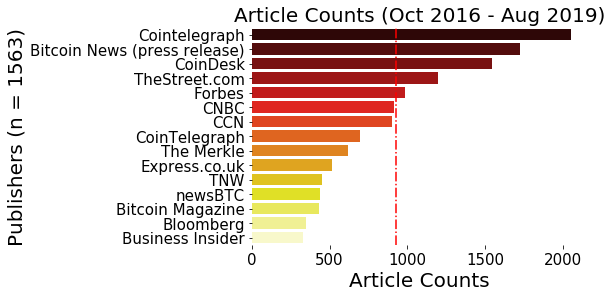

In [773]:
# Plot the top 15 publishers by article count
top_15_publishers = df_news_sentiment['publisher'].value_counts()[0:15]
sns.barplot(y=top_15_publishers.index,
            x=top_15_publishers.values,
            palette="hot")

# Hide unnecessary spines for a cleaner plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Set font sizes for various plot elements
plt.rc('axes', titlesize=20)      #
plt.rc('axes', labelsize=20)      
plt.rc('xtick', labelsize=13)     
plt.rc('ytick', labelsize=13)     

plt.axvline(x=930, color='r', linestyle='-.')  

# Add labels and title to the plot
plt.ylabel('Publishers (n = 1563)')
plt.xlabel('Article Counts')
plt.title('Article Counts (Oct 2016 - Aug 2019)')

# Display the plot
plt.show()

# Obtain top 5 publisher names for further use
top_5_publishers = list(top_15_publishers.index[0:5])

### Profit Graphs from top publisher with different sentiment score

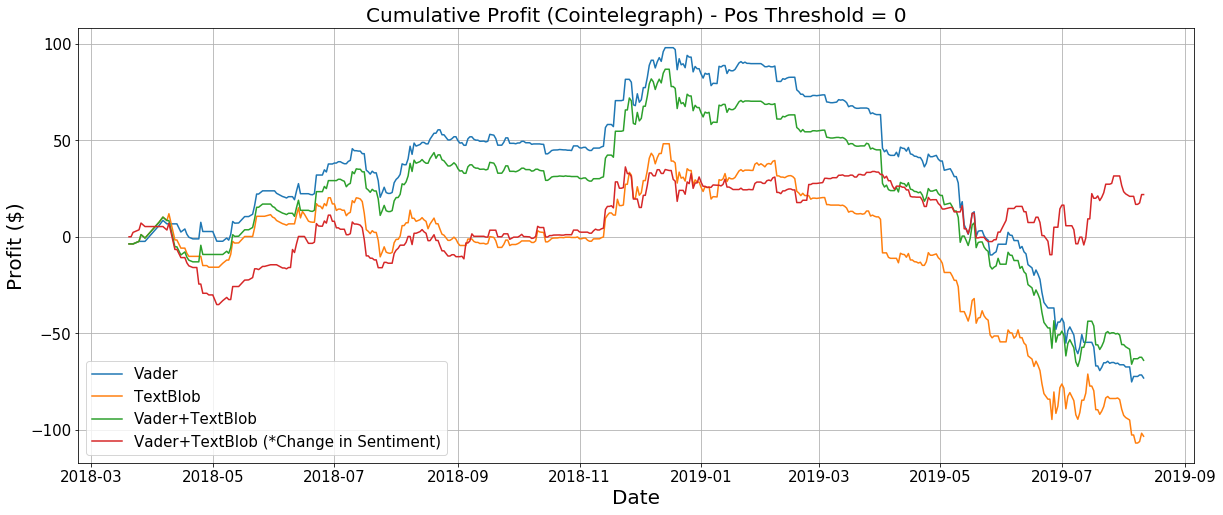

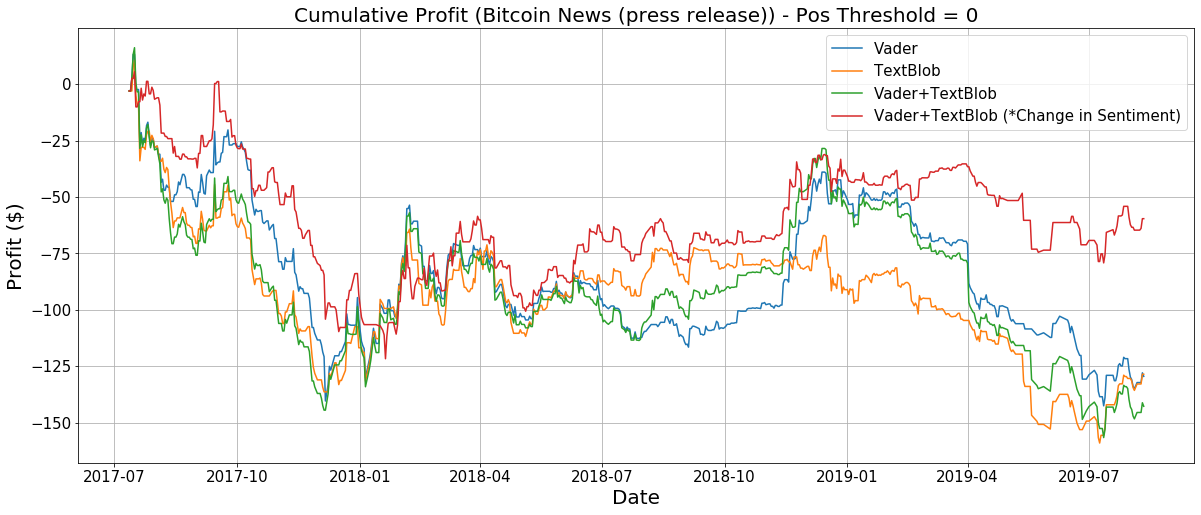

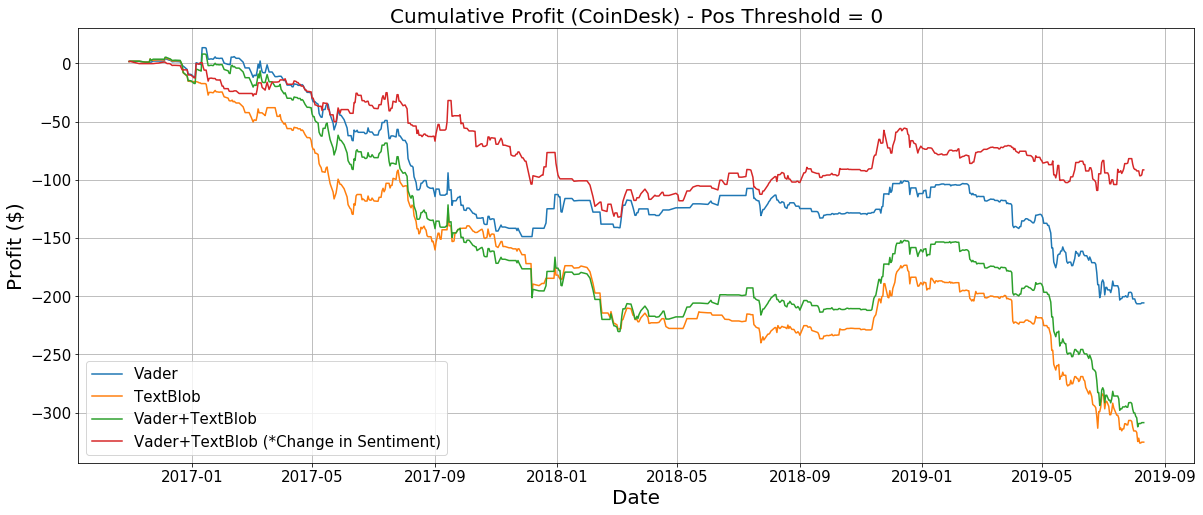

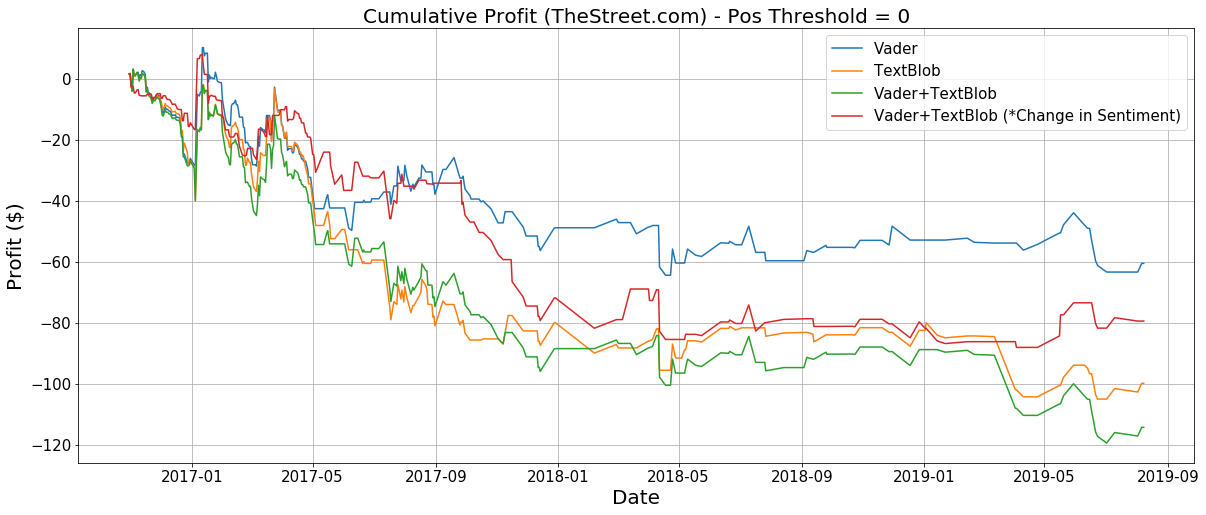

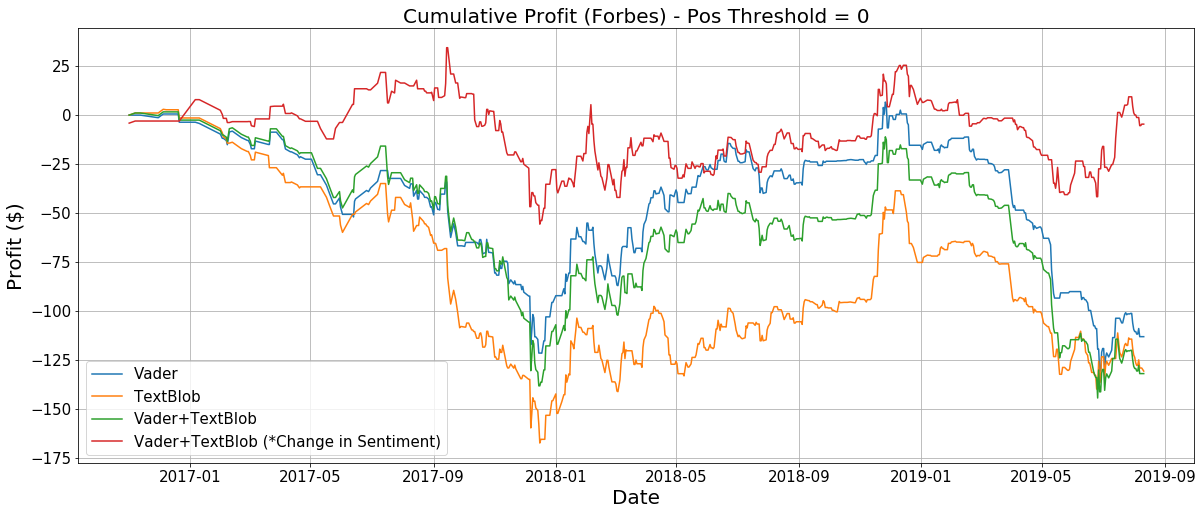

In [92]:
for publisher in top_5_publishers:
    graph_sentiment_profit(publisher,0,date(2015,6,8))

# Final Cumulative profit caculation

We will use Vader+TextBlob since it performed better than using raw sentiment scores

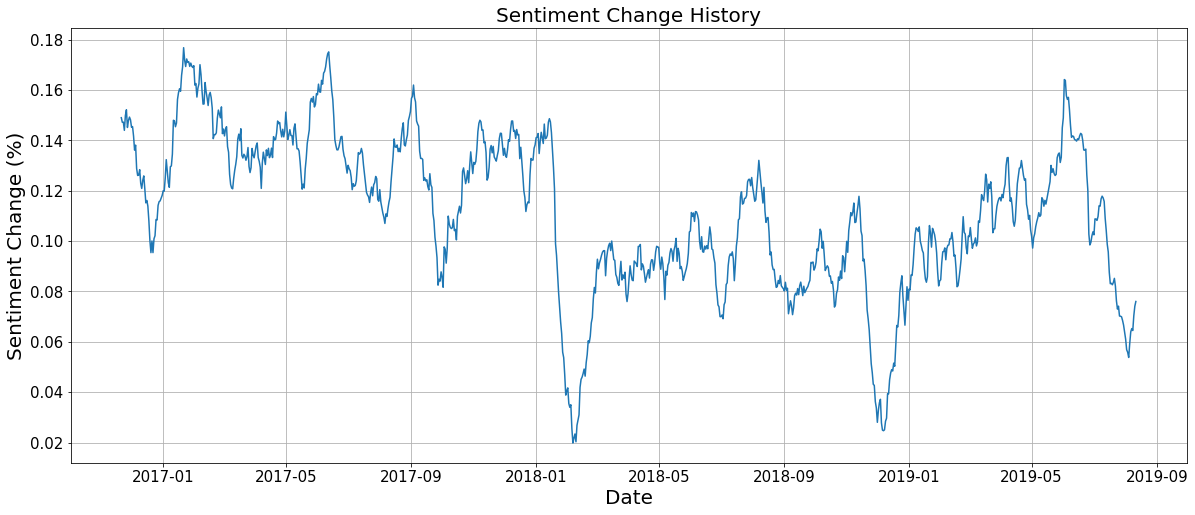

In [93]:
# Create a figure with specified size
plt.figure(figsize=(20, 8))

# Plot rolling average of final sentiment with a window of 24 on daily data
sns.lineplot(x=daily_sentiment_df['date'], y=daily_sentiment_df['vader+textblob_sentiment'].rolling(24).mean(), label='24-Period Rolling Avg')


# Set axis labels and plot title
plt.xlabel('Date')
plt.ylabel('Sentiment Change (%)')
plt.title('Historical Sentiment Change')

# Add a grid for better readability
plt.grid()

# Display the plot
plt.show()

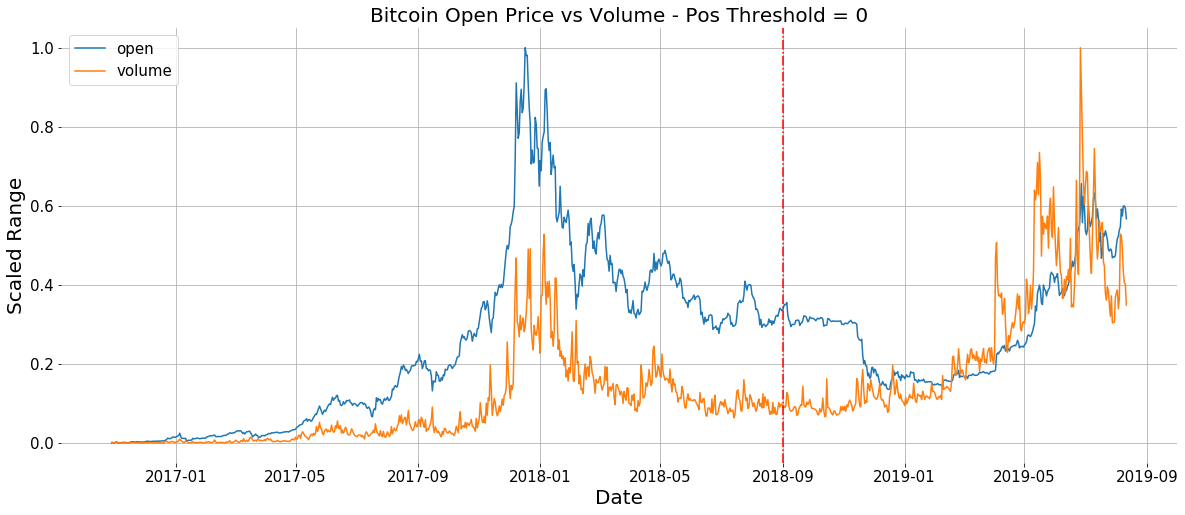

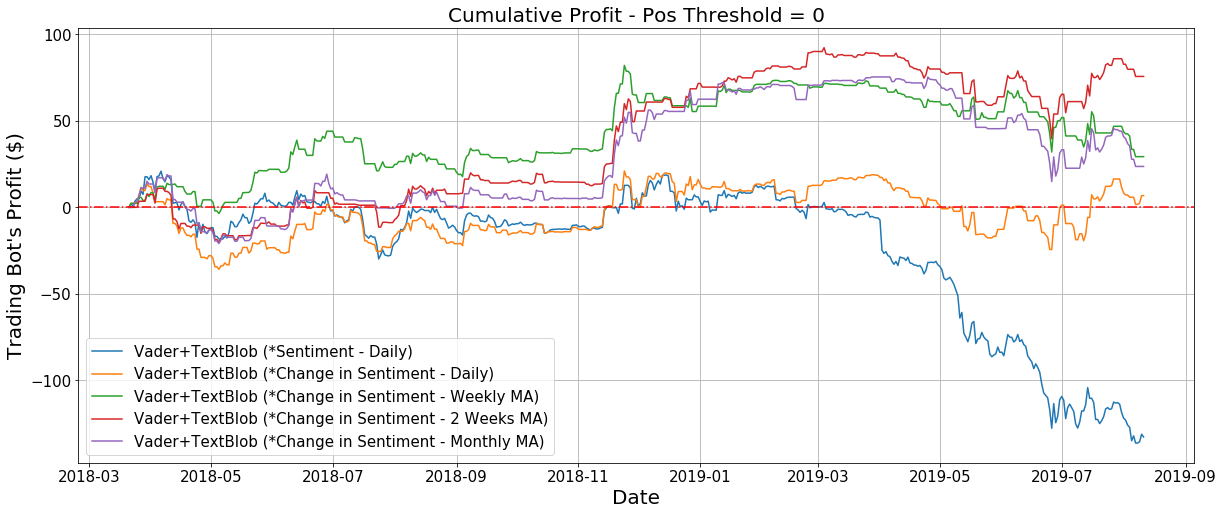

In [855]:
graph_sentiment_profit('all',0,date(2018, 3,20))

Text(0.5, 1.0, 'Raw Sentiment Distribution')

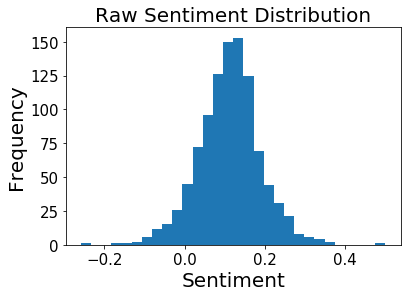

In [95]:
# Compound sentiment distribution
plt.hist(df_daily['vader+textblob_sentiment'],bins=30)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Raw Sentiment Distribution')

In [867]:
thresholds,raw_senti,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly = best_threshold(0,0.4,0.001,date(2015, 9, 1),date(2018, 3, 20))


100%|██████████| 400/400 [00:15<00:00, 21.32it/s]


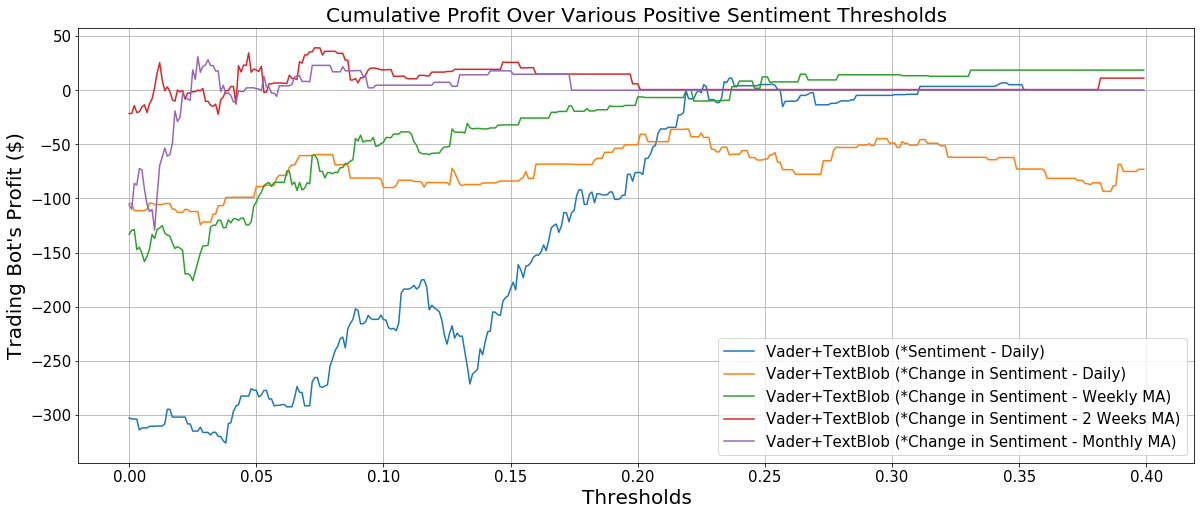

In [868]:
model_list = [raw_senti,senti_change_daily,senti_change_weekly,senti_change_2wk,senti_change_monthly]
threshold_vs_profit(thresholds,model_list)

In [872]:
print("Raw : ",thresholds[np.argmax(raw_senti)] )
print("Daily : ",thresholds[np.argmax(senti_change_daily)] )
print("Weekly : ",thresholds[np.argmax(senti_change_weekly)] )
print("Bieekly : ",thresholds[np.argmax(senti_change_2wk)] )
print("Monthly : ",thresholds[np.argmax(senti_change_monthly)] )

Raw :  0.23600000000000002
Daily :  0.219
Weekly :  0.331
Bieekly :  0.073
Monthly :  0.027


# Bitcoin Price Prediction

## Preparing features for LSTM training

### View Heatmap of Features to Target

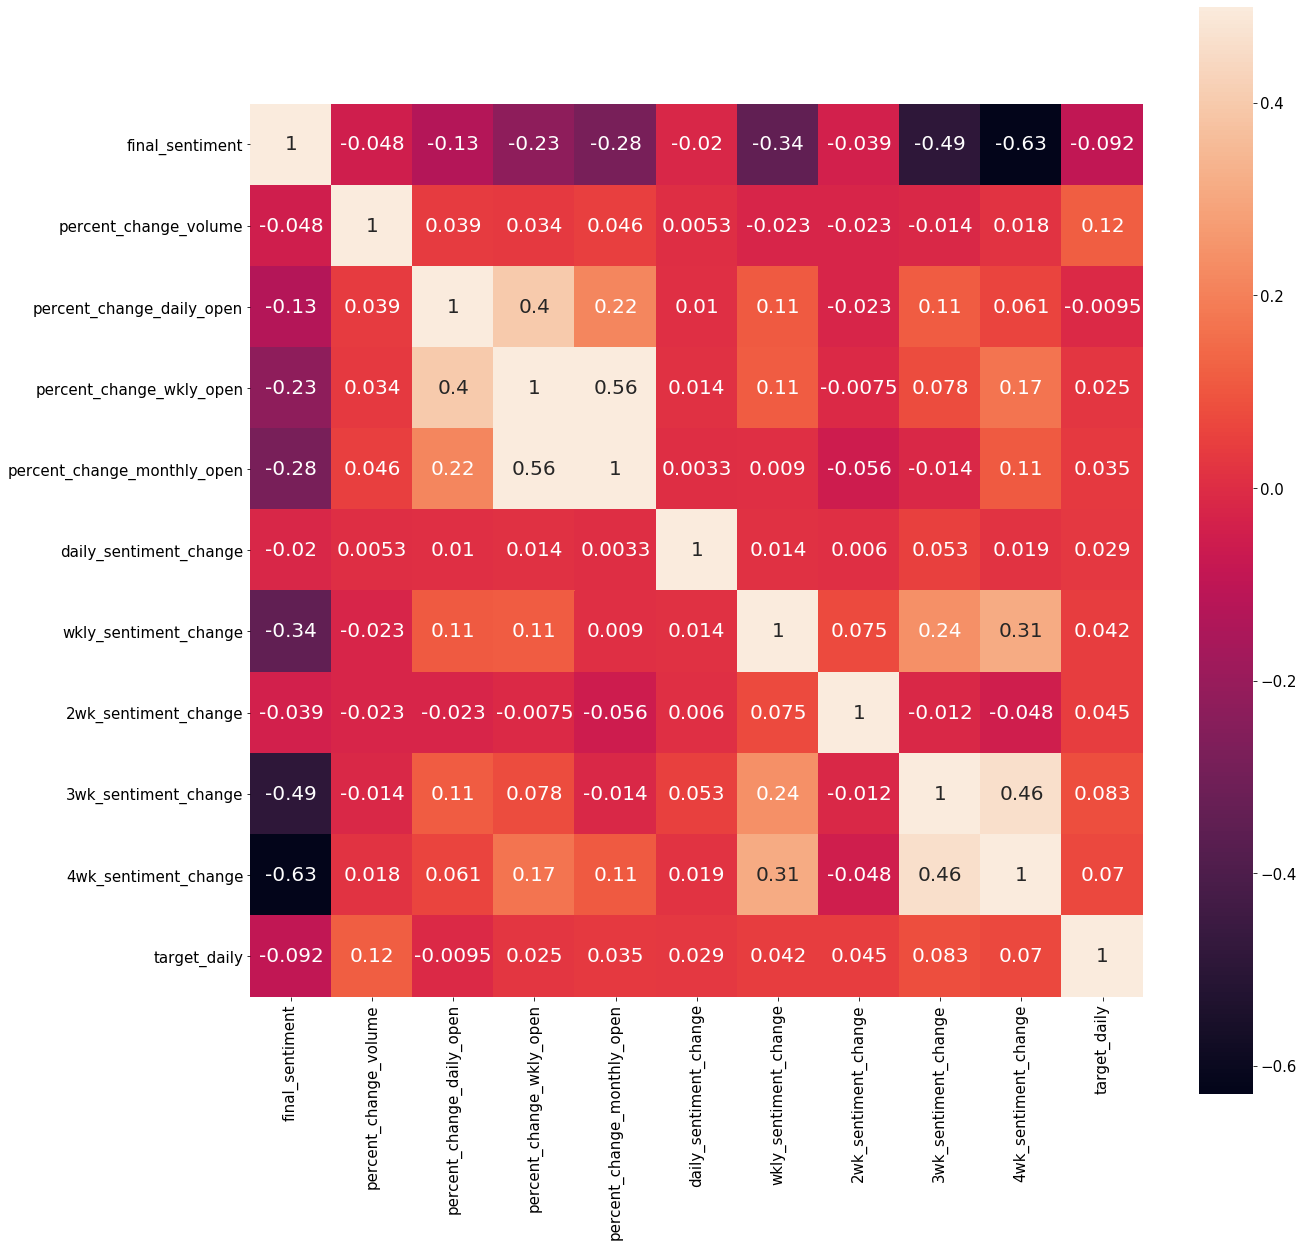

In [190]:
C_mat = df_daily.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

### Add LDA Topic Probability Features

In [449]:
from gensim.corpora import Dictionary
dic = Dictionary([df_news_clean['title_intro_clean']])
vec_bows=[]
for ix,item in enumerate(corpus):
    vec_bows.append(item)

vec_lda_topics=[lda[vec_bow] for vec_bow in vec_bows]

lda_vector = []
for id,vec_lda_topic in enumerate(vec_lda_topics):
    lda_vector.append(vec_lda_topic)
    
num_topic = 13
lda_topic_vectors = []
for vector in lda_vector:
    empty_dict = {x:0 for x in range(num_topic)}
    for topic in vector:            
        empty_dict[topic[0]]=topic[1]
    lda_topic_vectors.append(list(empty_dict.values()))
    
# Create DF of lda topic vectors and turn it groupby date
df_lda = pd.DataFrame(lda_topic_vectors)
df_lda['date'] = df_news_sentiment['date']
df_lda_daily = df_lda.groupby(by=['date'],as_index=False,).mean()

# Merge lda vector to main dataframe
df_daily = df_daily.merge(df_lda_daily, left_on='date', right_on='date')

## LSTM

### Prepare data for training

In [ ]:
# Parameters for train/test split
min_date = date(2014,6,1)
max_date = date(2019,3,1)
date_gap = 8
max_max_date = date(2020,1,1)
train_cols = [
              'vader+textblob_sentiment','open','high', 'low', 'close', 'volume','market_cap',
             'percent_change_volume','percent_change_daily_close','daily_sentiment_change',
              'percent_change_wkly_close','wkly_sentiment_change'
             ]
x_train, x_test, data_scaler = custom_train_test_split(df_daily,train_cols,date_gap, min_date,max_date,max_max_date )

# Parameters for processing data for LSTM input
BATCH_SIZE = 8 # Small batch_size increase train time and too big batch size reduce model's ability to generalize, but quicker
TIME_STEPS = 28 # how far it looks back
y_col_index = np.where(np.array(train_cols) == 'close')[0][0]

x_t, y_t = build_timeseries(x_train, TIME_STEPS, y_col_index)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test,TIME_STEPS, y_col_index)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

### Define and Train LSTM

In [296]:
# Start LSTM Model & Train
lstm_model = create_model(0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

training_history = lstm_model.fit(x_t, y_t, epochs=200, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_vfrom datetime import date
import numpy as np

# Parameters for custom train/test split function
start_train_date = date(2014, 6, 1)
end_train_date = date(2019, 3, 1)
test_data_gap = 8
end_test_date = date(2020, 1, 1)

# Columns to include in training features
feature_columns = [
    'vader_textblob_sentiment', 'open', 'high', 'low', 'close', 'volume', 'market_cap',
    'percent_change_volume', 'percent_change_daily_close', 'daily_sentiment_change',
    'percent_change_weekly_close', 'weekly_sentiment_change'
]

# Perform custom train/test split on the dataframe
X_train, X_test, feature_scaler = custom_train_test_split(
    df_daily, feature_columns, test_data_gap, start_train_date, end_train_date, end_test_date
)

# Parameters for LSTM input preparation
BATCH_SIZE = 8  # Small batch_size can increase training time but helps generalization, larger batch sizes speed up training but risk overfitting
LOOKBACK_STEPS = 28  # Number of previous timesteps LSTM will use as input
target_column_index = np.where(np.array(feature_columns) == 'close')[0][0]

# Generate timeseries data for training
X_train_timeseries, y_train_timeseries = build_timeseries(X_train, LOOKBACK_STEPS, target_column_index)

# Trim datasets to fit the batch size
X_train_trimmed = trim_dataset(X_train_timeseries, BATCH_SIZE)
y_train_trimmed = trim_dataset(y_train_timeseries, BATCH_SIZE)

# Prepare timeseries data for testing and validation
X_test_timeseries, y_test_timeseries = build_timeseries(X_test, LOOKBACK_STEPS, target_column_index)

# Split the test data into validation and test sets, trimmed to fit batch size
X_val, X_test_final = np.split(trim_dataset(X_test_timeseries, BATCH_SIZE), 2)
y_val, y_test_final = np.split(trim_dataset(y_test_timeseries, BATCH_SIZE), 2)al, BATCH_SIZE)), callbacks=callbacks_list)

Train and Test size 845 175



length of time-series i/o (817, 28, 12) (817,)



length of time-series i/o (147, 28, 12) (147,)
Train on 816 samples, validate on 72 samples
Epoch 1/200
 - 12s - loss: 0.0658 - val_loss: 0.0248
Epoch 2/200
 - 1s - loss: 0.0124 - val_loss: 0.0248
Epoch 3/200
 - 1s - loss: 0.0069 - val_loss: 0.0127
Epoch 4/200
 - 1s - loss: 0.0054 - val_loss: 0.0093
Epoch 5/200
 - 1s - loss: 0.0045 - val_loss: 0.0054
Epoch 6/200
 - 1s - loss: 0.0041 - val_loss: 0.0039
Epoch 7/200
 - 1s - loss: 0.0038 - val_loss: 0.0054
Epoch 8/200
 - 1s - loss: 0.0034 - val_loss: 0.0050
Epoch 9/200
 - 1s - loss: 0.0030 - val_loss: 0.0036
Epoch 10/200
 - 1s - loss: 0.0028 - val_loss: 0.0036
Epoch 11/200
 - 1s - loss: 0.0027 - val_loss: 0.0040
Epoch 12/200
 - 1s - loss: 0.0025 - val_loss: 0.0036
Epoch 13/200
 - 1s - loss: 0.0024 - val_loss: 0.0036
Epoch 14/200
 - 1s - loss: 0.0022 - val_loss: 0.0041
Epoch 15/200
 - 1s - loss: 0.0020 - val_loss: 0.0020
Epoch 16/200
 - 1s - loss: 0.0021 - val_loss: 0.0027
Epoch 17/200
 - 1s - loss: 0.0021 - val_loss: 0.0022
Epoch 18/200
 

### Visualize LSTM Model Output

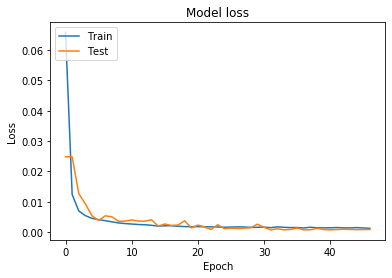

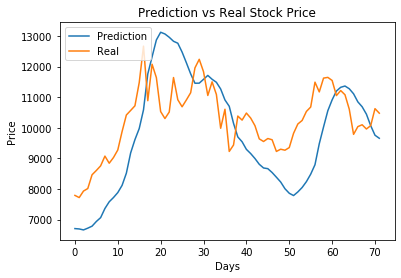

In [297]:
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Visualize training and validation loss over epochs
plt.figure()
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Make predictions using the LSTM model
y_pred = load_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()

# Trim test labels to match batch size
y_test_trimmed = trim_dataset(y_test_t, BATCH_SIZE)

# Reverse scaling of predicted and actual values
y_pred_original = (y_pred * data_scaler.data_range_[3]) + data_scaler.data_min_[3]
y_test_original = (y_test_trimmed * data_scaler.data_range_[3]) + data_scaler.data_min_[3]

# Plot predictions vs actual stock prices
plt.figure()
plt.plot(y_pred_original, label='Predicted Stock Price')
plt.plot(y_test_original, label='Actual Stock Price')
plt.title('Predicted vs Actual Stock Prices')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()